ADF Test for Differenced Data:
ADF Statistic: -7.152765612861307
p-value: 3.1101451967708665e-10
The series is Stationary


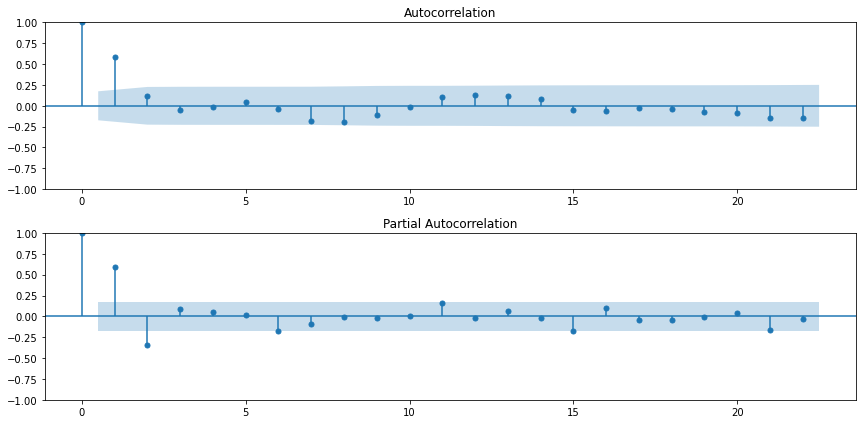

Best ARIMA parameters: (0, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46385D+00    |proj g|=  6.66505D-02


 This problem is unconstrained.



At iterate    5    f=  2.28713D+00    |proj g|=  5.51679D-03

At iterate   10    f=  2.28547D+00    |proj g|=  6.23092D-03

At iterate   15    f=  2.28466D+00    |proj g|=  2.33019D-03

At iterate   20    f=  2.28459D+00    |proj g|=  1.16165D-03

At iterate   25    f=  2.28458D+00    |proj g|=  4.36176D-04

At iterate   30    f=  2.28458D+00    |proj g|=  5.41423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   5.414D-05   2.285D+00
  F =   2.2845766376864836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

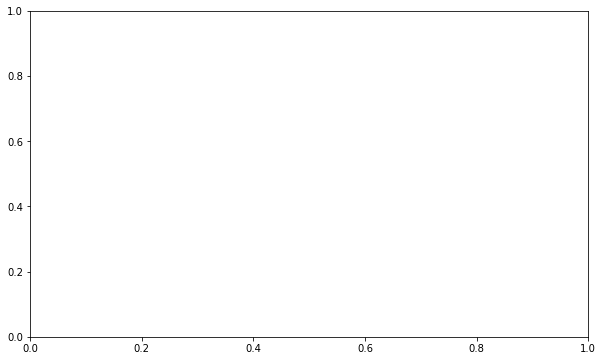

In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Load your dataset
df = pd.read_csv("Dal_Price.csv")

# Step 2: Convert 'Month' column to datetime and set it as the index
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')  # Handle invalid parsing with 'coerce' to NaT
df.dropna(subset=['Month'], inplace=True)  # Drop rows where 'Month' is NaT
df.set_index('Month', inplace=True)

# Step 3: Perform differencing to make the data stationary
df['Price Difference'] = df['Price'].diff().dropna()

# Step 4: Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The series is Non-Stationary")
    else:
        print("The series is Stationary")

# Test the differenced data
print("ADF Test for Differenced Data:")
adf_test(df['Price Difference'])

# Step 5: Plot the ACF and PACF to choose p and q parameters
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Price Difference'].dropna(), ax=plt.gca())
plt.subplot(212)
plot_pacf(df['Price Difference'].dropna(), ax=plt.gca())
plt.tight_layout()
plt.show()

# Step 6: Perform a grid search to find the best ARIMA(p, d, q) model
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
for param in pdq:
    try:
        temp_model = ARIMA(df['Price'], order=param)
        temp_model_fit = temp_model.fit()
        if temp_model_fit.aic < best_aic:
            best_aic = temp_model_fit.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq}')

# Step 7: Define the training set
train = df['Price']  # You can choose a portion of the data for training if needed

# Step 8: Fit the SARIMA model on the training set
seasonal_model = SARIMAX(train, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Step 9: Define the forecast period
future_start_date = '2024-09-01'  # Start from September 2024
future_end_date = '2034-12-01'    # End at December 2034
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='MS')

# Step 10: Forecast for the future period (from September 2024 to December 2034)
future_forecast_steps = len(future_dates)  # Calculate the number of steps
future_forecast = seasonal_model_fit.forecast(steps=future_forecast_steps)

# Step 11: Create a Pandas Series for the future forecast
future_forecast_series = pd.Series(future_forecast, index=future_dates)

# Step 12: Plot original vs. predicted

plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df.index, df['Price'], label='Original Data', color='blue')

# Plot the forecasted data
plt.plot(future_forecast_series.index, future_forecast_series, label='Predicted Data', color='red', linestyle='dashed')

# Add labels and title
plt.title('Original vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()
# Step 12: Combine original and predicted values into a single Pandas Series

# Create a copy of the original 'Price' series (to avoid modifying the original DataFrame)
combined_series = df['Price'].copy()

# Concatenate the original series with the predicted values
combined_series = pd.concat([combined_series, future_forecast_series])

# Display the combined series
print(combined_series)


In [ ]:
# Step 12: Combine original and predicted values into a single Pandas Series

# Create a copy of the original 'Price' series (to avoid modifying the original DataFrame)
combined_series = df['Price'].copy()

# Concatenate the original series with the predicted values
combined_series = pd.concat([combined_series, future_forecast_series])

# Display the combined series
print(combined_series)


In [ ]:
# # Slicing the combined series between two dates
# sliced_series = combined_series.loc['2032-08-01':]

# # Display the sliced series
# print(sliced_series)


In [3]:
# Step 13: Calculate Accuracy using MAPE
import numpy as np
# Split data into training and test sets
# Assuming you want to compare forecast with actual data, use the end portion of the actual data as 'test'
train_size = int(len(df) * 0.8)  # Use 80% for training
train_data, test_data = df['Price'][:train_size], df['Price'][train_size:]

# Fit the SARIMA model again on the training data
seasonal_model = SARIMAX(train_data, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Forecast the test period (use the length of the test set)
forecast_steps = len(test_data)
predicted_test = seasonal_model_fit.forecast(steps=forecast_steps)

# Step 14: Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(test_data, predicted_test)
accuracy = 100 - mape

# Print the accuracy
print(f'Model Accuracy: {accuracy:.2f}%')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43384D+00    |proj g|=  7.59787D-02


 This problem is unconstrained.



At iterate    5    f=  2.28761D+00    |proj g|=  1.43347D-01

At iterate   10    f=  2.27072D+00    |proj g|=  6.44376D-03

At iterate   15    f=  2.26910D+00    |proj g|=  2.37028D-03

At iterate   20    f=  2.26891D+00    |proj g|=  4.75011D-04

At iterate   25    f=  2.26889D+00    |proj g|=  2.46284D-04

At iterate   30    f=  2.26889D+00    |proj g|=  1.55415D-04

At iterate   35    f=  2.26889D+00    |proj g|=  4.78657D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     46      1     0     0   4.787D-06   2.269D+00
  F =   2.2688852677915863     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [5]:
import pickle

# Step 8: Fit the SARIMA model on the training set
seasonal_model = SARIMAX(train, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Save the model as a pickle file
with open('sarima_model.pkl', 'wb') as file:
    pickle.dump(seasonal_model_fit, file)

# Now you can load the model later using:
# with open('sarima_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46385D+00    |proj g|=  6.66505D-02


 This problem is unconstrained.



At iterate    5    f=  2.28713D+00    |proj g|=  5.51679D-03

At iterate   10    f=  2.28547D+00    |proj g|=  6.23092D-03

At iterate   15    f=  2.28466D+00    |proj g|=  2.33019D-03

At iterate   20    f=  2.28459D+00    |proj g|=  1.16165D-03

At iterate   25    f=  2.28458D+00    |proj g|=  4.36176D-04

At iterate   30    f=  2.28458D+00    |proj g|=  5.41423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   5.414D-05   2.285D+00
  F =   2.2845766376864836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [ ]:
import joblib

In [ ]:
joblib.dump(seasonal_model_fit, 'sarima_model.pkl')

In [6]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
